---
title: |
  \normalsize Course M-GFP3: Imaging and non-imaging spectroscopy:\
  Term Paper
subtitle:
  \Large Strategies to enhance predictive modeling of soil organic carbon (SOC) using the LUCAS topsoil spectral library.

author: "Chinthaparthy Deepak Reddy, Khuzaima, Luis"
date: "February 20, 2025"

# Formatting
format:
  pdf:
    documentclass: scrartcl
    papersize: letter
    toc: true
    toc-depth: 3
    number-sections: true
    colorlinrandom: true
    linkcolor: blue
    urlcolor: blue
    citecolor: blue
    
    geometry:
      - margin=1in
    highlight-style: gruvbox
    code-block-background: true
    code-fold: true
    code-overflow: scroll
    fig-pos: "H"
    include-in-header: 
      text: |
        \usepackage{tcolorbox}
        \usepackage{float}
        \usepackage{booktabs}
        \usepackage{longtable}
        \tcbuselibrary{skins,breakable}

######## Execution options
execute:
  echo: true
  warning: false
  message: false
  cache: true

######## Bibliography if needed
######## bibliography: references.bib
---

# Markdown structure

After each major task, we have provided a **detailed overview** to summarize what was done and the results of that particulat task.


# Packages

In [55]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import own_functions

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, pairwise_distances, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
import autogluon

# Data

**TASK 1**

Data splitting (5 P):

- Split your data into a calibration data set (~70%) and an independent test data set (~30%). 
- Show that both are representative of the full data set.
-  For procedures with randomized approaches, please define and note the seed (in R: set.seed( ) ) to make the split reproducible for the instructors. 
- From this point onward, the composition of the test data set must remain constant and unchanged for all subsequent tasks

## Load and Clean

In [59]:
# Load data
data = pd.read_csv('data/France_spc.csv')

# Remove unnecessary column
data = data.drop(columns=['Unnamed: 0'])

print(f"Data rows: {data.shape[0]}, columns: {data.shape[1]}")
display(data.head())

Data rows: 2807, columns: 1000


,500,502,504,506,508,510,512,514,516,518,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,0.137399,0.139045,0.140758,0.142544,0.144388,0.146281,0.148221,0.150205,0.152239,0.154322,...,0.380845,0.379886,0.378946,0.378047,0.377186,0.376361,0.375612,0.374935,0.374315,0.373759
1,0.141740,0.142851,0.144007,0.145208,0.146450,0.147726,0.149025,0.150348,0.151702,0.153081,...,0.261258,0.260330,0.259418,0.258505,0.257603,0.256744,0.255934,0.255173,0.254467,0.253815
2,0.140713,0.142216,0.143778,0.145392,0.147053,0.148756,0.150488,0.152257,0.154059,0.155892,...,0.402253,0.401367,0.400499,0.399693,0.398964,0.398307,0.397749,0.397298,0.396927,0.396609
3,0.128922,0.129908,0.130919,0.131959,0.133019,0.134102,0.135196,0.136307,0.137433,0.138571,...,0.331686,0.331122,0.330591,0.330075,0.329612,0.329210,0.328841,0.328509,0.328244,0.328046
4,0.161760,0.163229,0.164741,0.166298,0.167895,0.169530,0.171194,0.172890,0.174611,0.176356,...,0.404026,0.403154,0.402350,0.401604,0.400916,0.400319,0.399808,0.399354,0.398933,0.398586


In [60]:
target_raw = pd.read_csv('data/France_lab.csv')
lat_lon = target_raw[['GPS_LAT', 'GPS_LONG']]
target = target_raw['SOC']
print(f"Target rows: {target.shape[0]}")

Target rows: 2807


In [61]:
target_raw

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
0,1,10000,40.0,52.0,8.0,15.6,1,1.4,42.6,491.1,24.6,WGS84,45.893933,4.680379,B82,E10,U111,8,mineral,FRANCE
1,2,10001,26.0,18.0,56.0,19.8,1,1.6,19.5,279.1,20.6,WGS84,45.816720,4.584692,E10,8,U370,8,mineral,FRANCE
2,3,10002,22.0,41.0,37.0,33.5,1,2.6,37.8,399.1,15.0,WGS84,45.983716,4.671533,E10,8,U111,8,mineral,FRANCE
3,4,10004,27.0,47.0,26.0,66.1,21,6.6,147.7,1080.6,30.5,WGS84,45.908022,4.601575,E10,8,U111,8,mineral,FRANCE
4,5,10005,16.0,32.0,52.0,38.1,0,2.6,49.6,293.9,7.8,WGS84,46.082345,4.480490,E20,8,U111,8,mineral,FRANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,2803,9994,19.0,62.0,19.0,9.1,0,1.2,44.5,131.8,9.7,WGS84,45.615242,4.887293,B31,8,U111,8,mineral,FRANCE
2803,2804,9995,16.0,41.0,42.0,13.4,0,1.4,33.0,184.4,7.2,WGS84,45.713629,5.058028,B16,8,U111,8,mineral,FRANCE
2804,2805,9996,13.0,29.0,58.0,8.7,3,1.3,104.9,425.4,7.7,WGS84,45.767539,5.053155,B16,8,U111,8,mineral,FRANCE
2805,2806,9997,20.0,38.0,42.0,30.6,0,3.0,56.1,107.8,12.6,WGS84,45.788303,4.381513,E20,8,U111,8,mineral,FRANCE


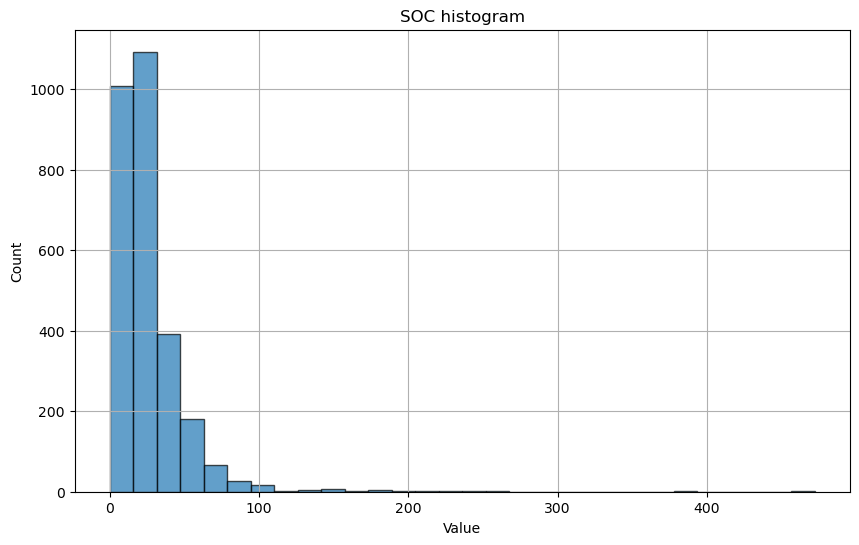

In [62]:
# plot soc histogram
plt.figure(figsize=(10, 6))
plt.hist(target, bins=30, edgecolor='k', alpha=0.7)
plt.title('SOC histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

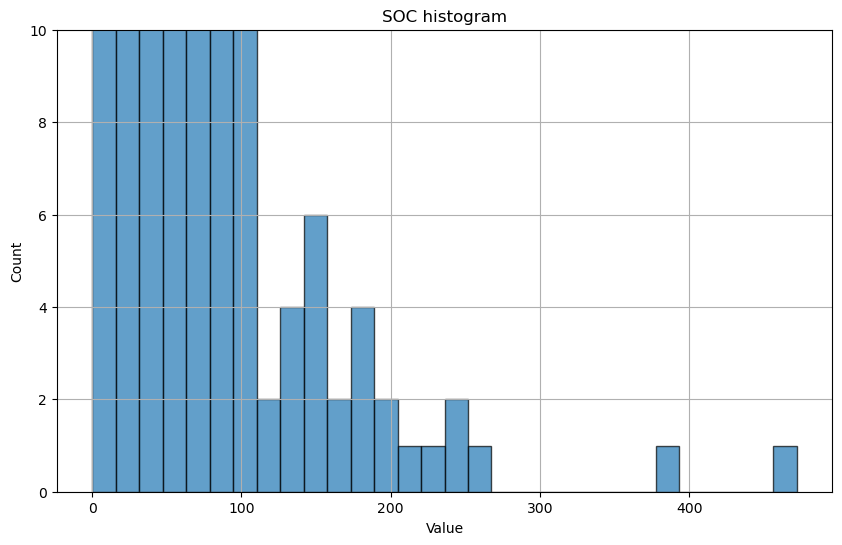

In [63]:
# plot soc histogram
plt.figure(figsize=(10, 6))
plt.hist(target, bins=30, edgecolor='k', alpha=0.7)
plt.title('SOC histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.ylim((0,10))
plt.grid(True)
plt.show()

## Sampling and Splitting

In [64]:
# Extract features and target as numpy array
X = data.values
y = target.values

In [65]:
### Sampling strategies
# Step 1: Generate or Load Data
np.random.seed(100)  # Set seed for reproducibility

# Step 2: Random Split (70% Calibration, 30% Test)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.3, random_state=100)

print(f"Random Split: {X_train_random.shape[0]} training samples, {X_test_random.shape[0]} test samples")

# Step 3: Apply Kennard-Stone to select 70% of the data
n_train = int(0.7 * X.shape[0])

# Get indices
ks_indices = own_functions.kennard_stone(X, n_train)

# Select Training data
X_train_ks = X[ks_indices,:]
y_train_ks = y[ks_indices]

# Select Test
test_indices = np.setdiff1d(np.arange(X.shape[0]), ks_indices)
X_test_ks = X[test_indices]
y_test_ks = y[test_indices]

print(f"Kennard-Stone: {X_train_ks.shape[0]} training samples, {X_test_ks.shape[0]} test samples")

# Step 4: PCA for Visualization
pca = PCA(n_components=2)

# Fit PCA on full data
X_pca = pca.fit_transform(X)  

# Transform data
X_train_random_pca = pca.transform(X_train_random)  # PCA on random calibration set
X_test_random_pca = pca.transform(X_test_random)  # PCA on random test set
X_cal_ks_pca = pca.transform(X_train_ks)  # PCA on Kennard-Stone calibration set
X_test_ks_pca = pca.transform(X_test_ks)  # PCA on Kennard-Stone test set

Random Split: 1964 training samples, 843 test samples
Kennard-Stone: 1964 training samples, 843 test samples


Random Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)

Kennard-Stone Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)


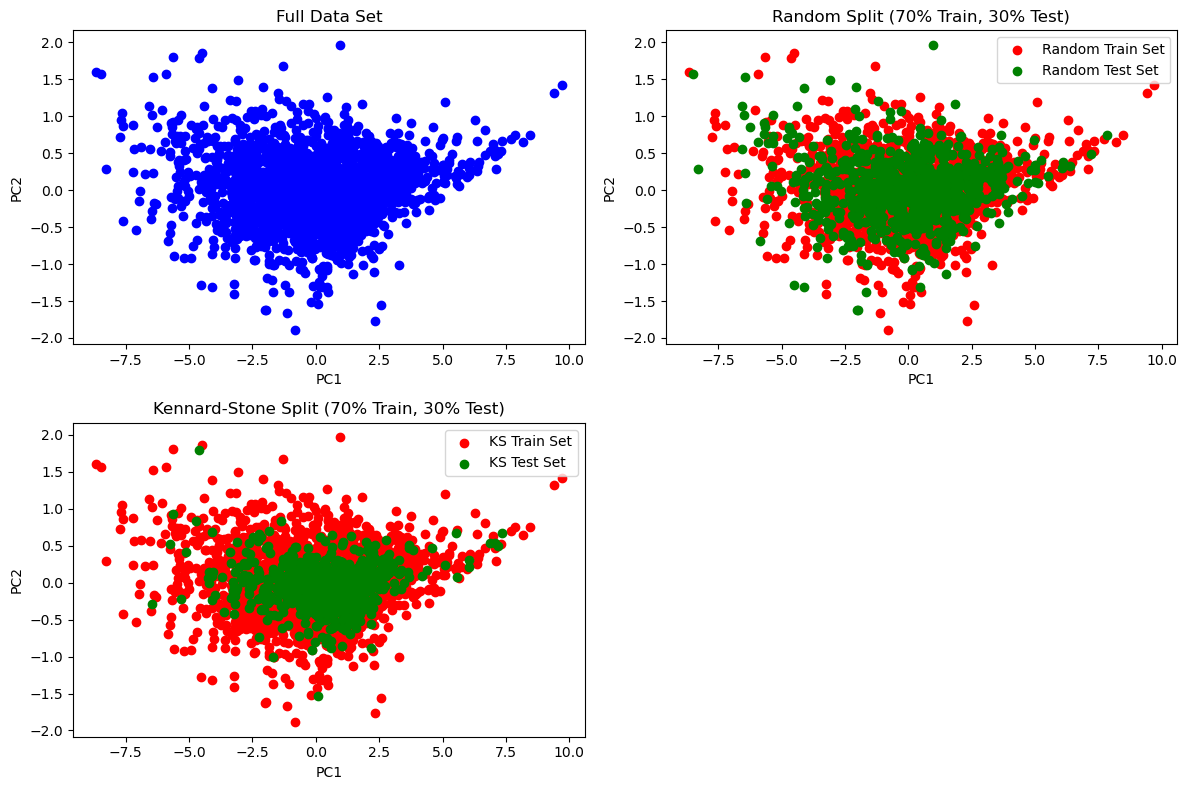

In [66]:
# Step 5: Plot Results
own_functions.plot_pca_comparison(X_full=X,
                                  X_train_random=X_train_random,
                                  X_test_random=X_test_random,
                                  X_train_ks=X_train_ks,
                                  X_test_ks=X_test_ks)

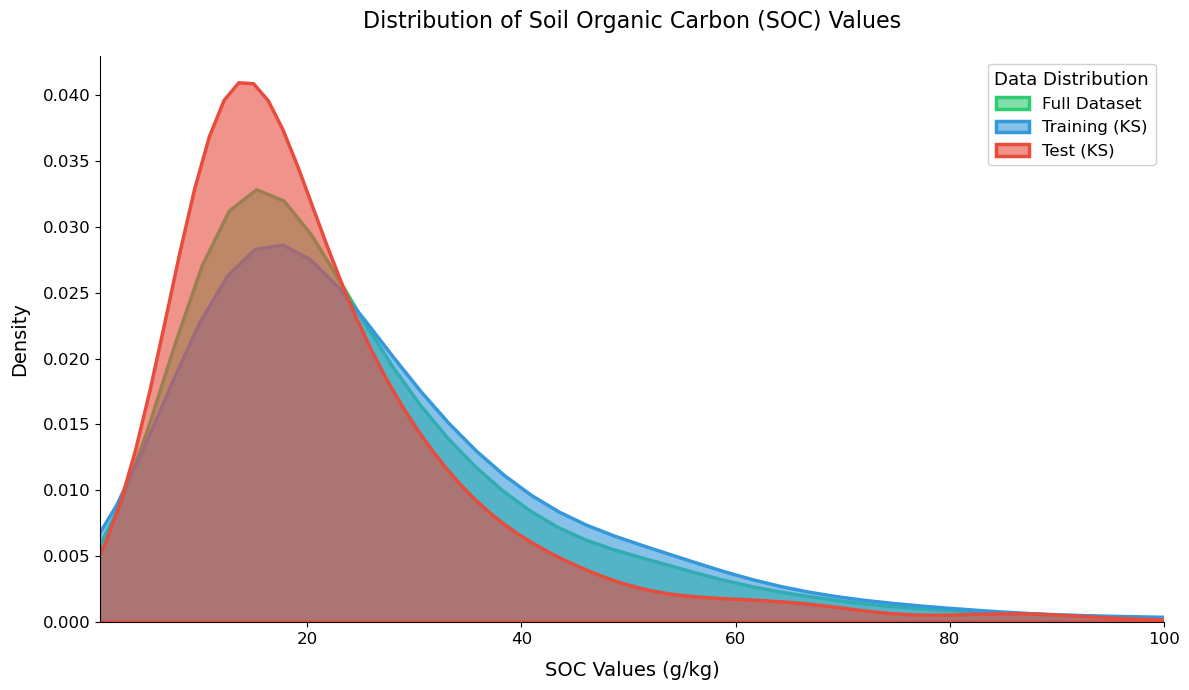

In [67]:
# Set up a larger figure for better visibility
plt.figure(figsize=(12, 7))

# Create DataFrames for all datasets (including full dataset)
df_full = pd.DataFrame({'SOC': y, 'Set': 'Full Dataset'})
df_train = pd.DataFrame({'SOC': y_train_ks, 'Set': 'Training (KS)'})
df_test = pd.DataFrame({'SOC': y_test_ks, 'Set': 'Test (KS)'})
df_combined = pd.concat([df_full, df_train, df_test])

# Define a nice color palette
colors = {'Full Dataset': '#2ecc71', 'Training (KS)': '#3498db', 'Test (KS)': '#e74c3c'}

# Plot each KDE separately to ensure proper legend handling
for dataset, color in colors.items():
    subset = df_combined[df_combined['Set'] == dataset]
    sns.kdeplot(data=subset, x='SOC', 
                fill=True, 
                alpha=0.6,
                linewidth=2.5,
                color=color,
                label=dataset,
                bw_adjust=1.2)  # Adjust bandwidth for smooth but still representative curves

# Enhance the plot aesthetics with better visibility
plt.title('Distribution of Soil Organic Carbon (SOC) Values', fontsize=16, pad=20)
plt.xlabel('SOC Values (g/kg)', fontsize=14, labelpad=10)
plt.ylabel('Density', fontsize=14, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=12)

# Create a more visible legend with explicit labels
plt.legend(title='Data Distribution', fontsize=12, title_fontsize=13, 
          loc='upper right', frameon=True, framealpha=0.9)

# Set x-axis limits to focus on the main distribution (exclude extreme outliers)
q1, q99 = np.percentile(y, [1, 99])
plt.xlim([max(0, q1-5), min(100, q99+10)])

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

In [68]:
X_train = X_train_ks
y_train = y_train_ks

X_test = X_test_ks
y_test = y_test_ks

In [69]:
#TODO: change text below: the KDE was only done for ks testing looking at training and test set!

## 1. Overview for first task **Data splitting (5 P)**
### Data
The dataset used for this study is based on **spectral data** and **Soil Organic Carbon (SOC)** measurements collected from  LUVAS data base of country**France**. The dataset consists of **2807 samples** (rows) and **1000 spectral bands** (columns), with reflectance values ranging from **500 nm to 2498 nm**. This data was collected to assess the spatial distribution of SOC using spectral reflectance, and it includes both the **SOC values**  along with so many other lab parameters and the corresponding **GPS coordinates** for geospatial analysis.

### Data Preprocessing


- We remove columns that is not required to the analysis, leaving behind a final working dataset.
- The target variable, **SOC**, is extracted, along with the **GPS coordinates** for each sample, to allow for potential geospatial analysis.

**Overview:** After preprocessing, we have a clean dataset containing spectral data and SOC values with corresponding GPS coordinates.

### Data Sampling

We employed two different sampling strategies to ensure that our model is robust and can generalize well:

1. **Random Split:**
   We performed a random split of the dataset, allocating **70%** for training (calibration) and **30%** for testing. This ensures that the model is trained on a representative portion of the data while still having a separate test set to evaluate its performance.

2. **Kennard-Stone Algorithm:**
   We applied the **Kennard-Stone algorithm** to select a calibration set that maximizes diversity in spectral space. The remaining samples are used as the independent test set. This approach ensures that the training data covers a broad range of spectral variations.

**Overview:** The data was split using two methods—random sampling and the Kennard-Stone algorithm—to ensure both representative and diverse training sets.

### Distribution Analysis

After splitting the dataset, we performed an analysis to confirm that the calibration and test sets properly represent the distribution of **SOC** values in the original dataset:

- We conducted **Principal Component Analysis (PCA)** to visualize the distribution of the data and verify that both the training and test sets are representative of the overall dataset.
- Additionally, we generated **Kernel Density Estimation (KDE)** plots to compare the **SOC distributions** across three groups:
  - The **full dataset**
  - The **randomly selected training set**
  - The **Kennard-Stone-based training set**

**Overview:** The distribution analysis confirmed that both sampling strategies preserved the statistical characteristics of the dataset, ensuring that our model will be trained on a representative set.

### Final Dataset Preparation

After confirming that the dataset was appropriately split and balanced, we are now ready to proceed with modeling using the **Kennard-Stone-selected calibration and test sets**.

**Overview:** The **Kennard-Stone** algorithm samples the extreme data points first and places them in the calibration data set, which makes the test data set less variable. But at the same time, the aim is to ensure that the calibration data set covers all eventualities. So we have used Kennard Stone data as final calibration and validation data.


**TASK 2**
# Basemodel

Baseline model (5 P):
- Develop a global baseline PLSR model using the *calibration dataset* 
  - (entire VNIR range from 500 nm to 2499 nm in steps of 2 nm) 
  - *without* applying any *spectral* *preprocessing*. 
- The target variable is soil organic carbon (SOC). 
- Perform *internal optimization* to *determine* the *optimal* *number* of *latent* *PLS* *variables* 
  -  *report your selected value*. 
- Apply the optimized model* to the independent test set*. 
  - Compute the validation metrics *(R², RMSE, bias, and RPD)*
  - *visualize* the results in a *scatter* *plot* (observed vs. predicted values) 
  - and assess the model's performance.

## Finding optimal number of components

Rough Optimization:   0%|          | 0/7 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

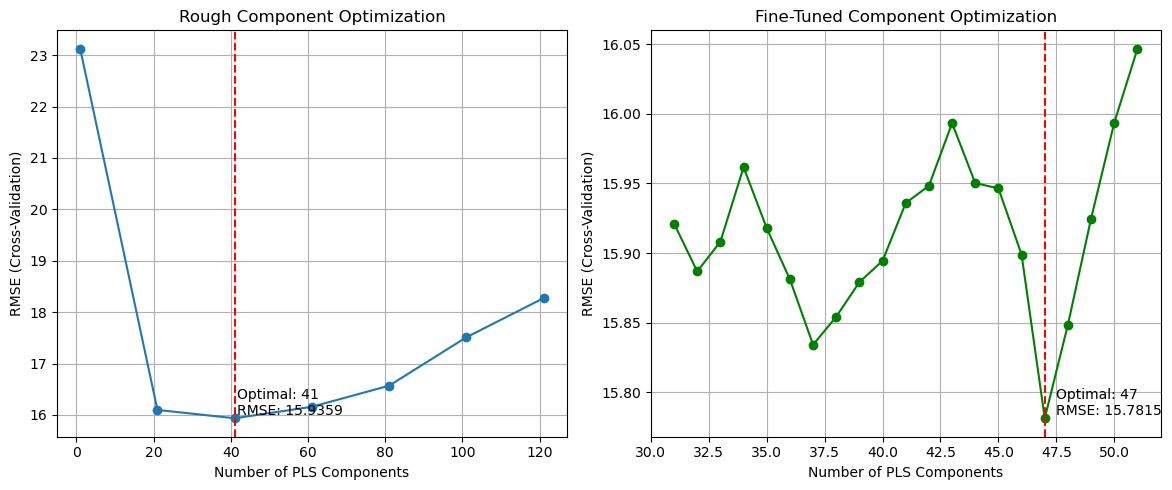

Optimal number of components: 47


In [ ]:
plsr_base_components = own_functions.optimize_pls_components(X_train=X_train, 
                                      y_train=y_train,
                                      max_components=140,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=False,
                                      plot_results=True
                                      )

## Evaluating Base Model

Root Mean Squared Error (RMSE): 10.0547
R²: 0.6552
Bias: -0.1772
RPD: 1.7030


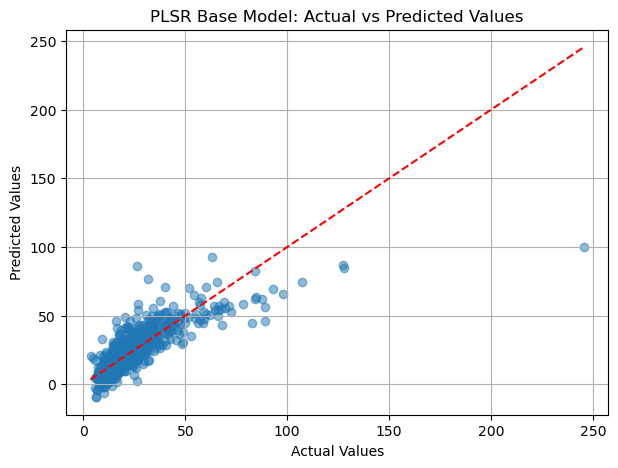

In [71]:
plsr_base_model = PLSRegression(n_components=plsr_base_components["optimal_n"])
plsr_base_model.fit(X_train, y_train)

plsr_base_eval = own_functions.evaluate_model(plsr_base_model,
                             X_test=X_test,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR Base Model'}
                             )

## 2. Overview for **Baseline Model Development (5 P)**

### Baseline Model

We have considered  or rather its part of task to consider a  baseline Partial Least Squares Regression (PLSR), in this regard we have developed the model using the **calibration dataset** (entire VNIR range from 500 nm to 2498 nm in steps of 2 nm) without applying any spectral preprocessing. The target variable for this model is **Soil Organic Carbon (SOC)** which is clearly explained in overview of Task 1.



### Internal Optimization for PLS Components

- **Objective:** Determine the optimal number of latent PLS variables as the only hyperparameter , no of latent component to enhance model performance.
- **Process:** The optimization was conducted in two stages to efficiently identify the optimal number of PLS components:
  1. **Coarse Optimization:** Initially, a broader search was performed with a step size of 20 components. This step helped in quickly narrowing down the range of potential optimal values.
  2. **Fine-Tuned Optimization:** Within the range identified in the coarse optimization, a finer search was conducted by evaluating components in the range of -10 to +10 around the initially identified optimum. This refinement allowed for precise determination of the optimal number of components.
- **Overview::** Through this two-stage optimization process, the optimal number of PLS components was determined to be **47**, which was identified during the fine-tuned stage starting from an initial estimate of ***40*** components.



### Model Evaluation

- **Application:** The optimized model was applied to the independent test set which was determined in previous task.
- **Metrics Computed:**

| Metric       | Value       |
|--------------|-------------|
| **RMSE**     | 10.0547     |
| **R²**       | 0.6552      |
| **Bias**     | -0.1772     |
| **RPD**      | 1.7030      |

- **Visualization:** A scatter plot was generated to visualize the observed vs. predicted values.
- **Performance Assessment:** The model's performance was assessed based on the computed metrics and visual inspection of the scatter plot.

**Overview:** The baseline PLSR model was optimized and evaluated, providing insights into its predictive performance for SOC using spectral data. The optimal number of PLS components was determined to be **47**, and the model's performance was assessed using various validation metrics.


**TASK 3**
# Model Improvement Strategies (5 P per strategy):
- Develop and evaluate three distinct strategies to improve the baseline model, 
  - using the **same independent test set for validation**. 
- For each strategy, report the validation metrics
    - (R², RMSE, bias, and RPD), 
    - visualize the best result in a scatter plot (observed vs.predicted values) 
    - assess the performance of these alternative models. 
    - Use the same independent test set for all strategies to ensure that validation metrics are directly comparable.


IMPORTANT: Testing two or more spectral preprocessing methods is considered one
strategy, not multiple strategies. Similarly, testing one or more alternative regression
algorithms counts as one strategy, not multiple.

## Strategy 1: Varying Preprocessing Strategy

The first strategy to improve the baseline model involves exploring different spectral preprocessing techniques to enhance the model's predictive performance. We tested the following preprocessing methods:

- **Savitzky-Golay Smoothing:**
- **Standard Normal Variate (SNV) Transformation:**
- **Absorbance Transformation:**

### Savitzgy-Golay

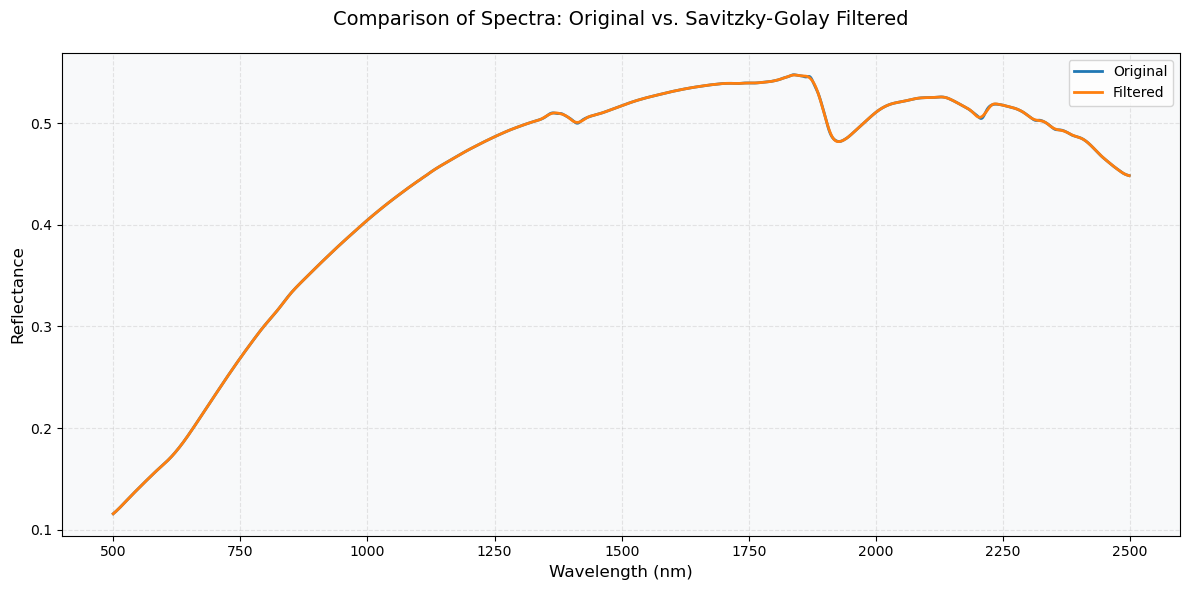

Optimal number of components: 37
Root Mean Squared Error (RMSE): 10.1694
R²: 0.6473
Bias: -0.1207
RPD: 1.6838


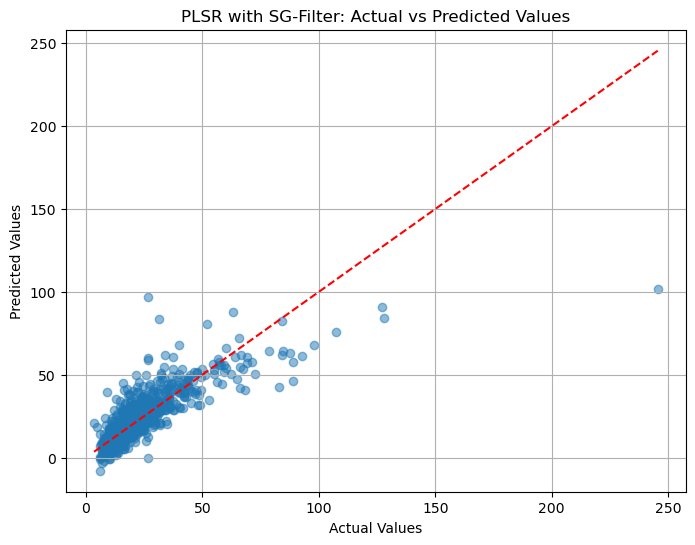

In [72]:
# Applying Savitzky-Golay filter to calibration and test data
X_train_sg = own_functions.apply_savitzky_golay(X_train, window_length=31, polyorder=4, deriv=0, delta=2)
X_test_sg = own_functions.apply_savitzky_golay(X_test, window_length=31, polyorder=4, deriv=0, delta=2)

# Plot spectra comparison
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_sg[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'Filtered'],
    title='Comparison of Spectra: Original vs. Savitzky-Golay Filtered',
)

plsr_sgolay_components = own_functions.optimize_pls_components(X_train=X_train_sg, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=False,
                                      plot_results=False
                                      )

plsr_sg_model = PLSRegression(n_components=plsr_sgolay_components["optimal_n"])
plsr_sg_model.fit(X_train_sg, y_train)

plsr_sg_eval = own_functions.evaluate_model(plsr_sg_model,
                             X_test=X_test_sg,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with SG-Filter',
                                          'figsize': (8, 6)}
                             )

### Standard Normal Variate

In [73]:
# Applying Savitzky-Golay filter to calibration and test data
X_train_snv = own_functions.standard_normal_variate(X_train)
X_test_snv = own_functions.standard_normal_variate(X_test)

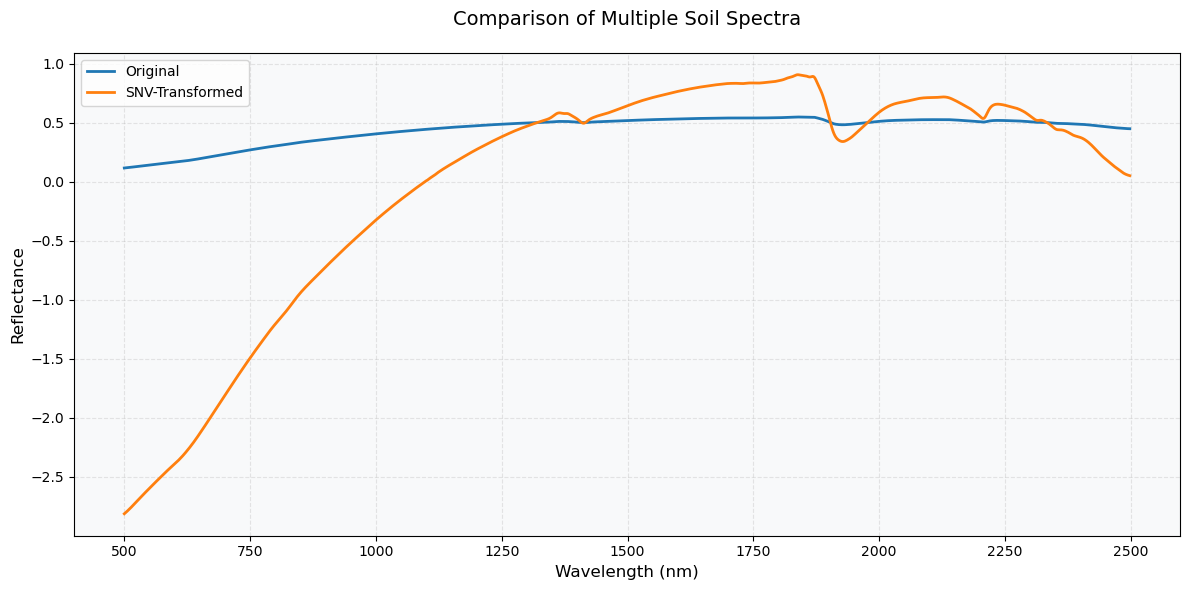

Optimal number of components: 40
Root Mean Squared Error (RMSE): 10.1517
R²: 0.6485
Bias: 0.3009
RPD: 1.6867


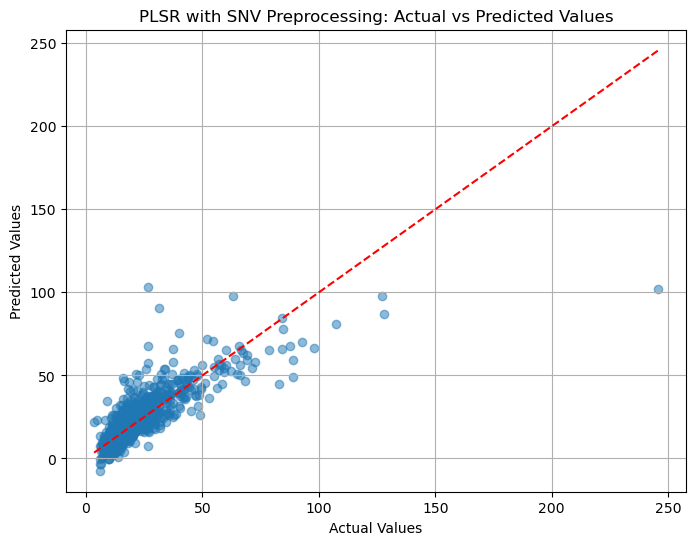

In [74]:
# Example usage with multiple spectra:
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_snv[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'SNV-Transformed'],
    title='Comparison of Multiple Soil Spectra'
)

plsr_snv_components = own_functions.optimize_pls_components(X_train=X_train_snv, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=False,
                                      plot_results=False
                                      )

plsr_snv_model = PLSRegression(n_components=plsr_snv_components["optimal_n"])
plsr_snv_model.fit(X_train_snv, y_train)

plsr_snv_eval = own_functions.evaluate_model(plsr_snv_model,
                             X_test=X_test_snv,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with SNV Preprocessing',
                             'figsize': (8, 6)}
                             )

### Absorbance

In [75]:
# Calculate pseudo abosrbance
X_train_absorb = np.log10(1/X_train)
X_test_absorb = np.log10(1/X_test)

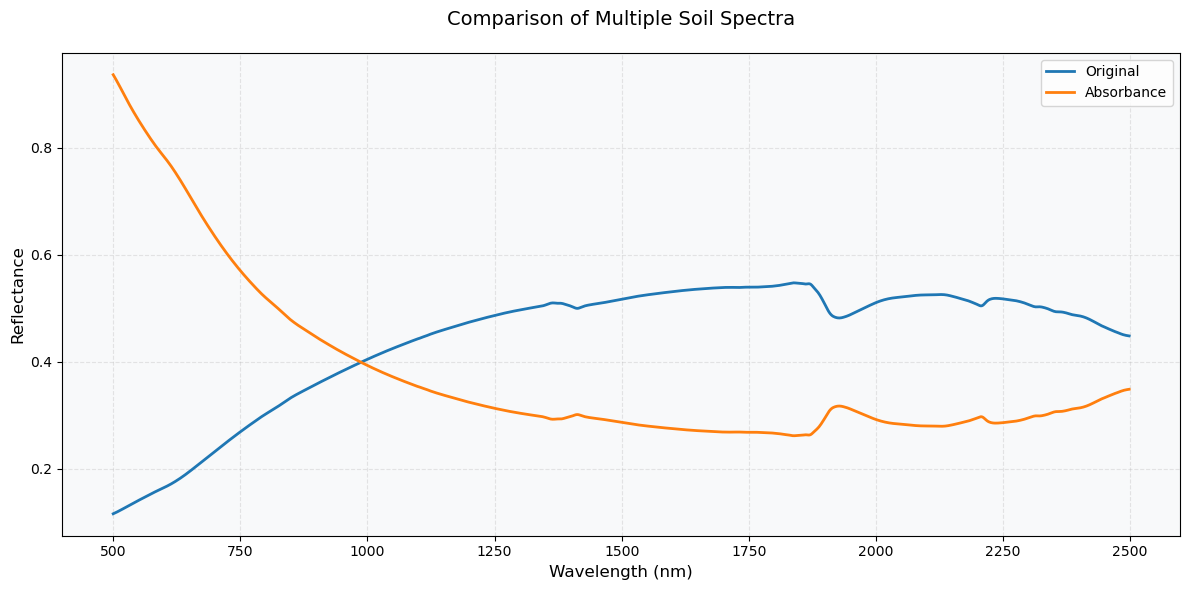

Optimal number of components: 48
Root Mean Squared Error (RMSE): 8.6069
R²: 0.7474
Bias: 0.1506
RPD: 1.9895


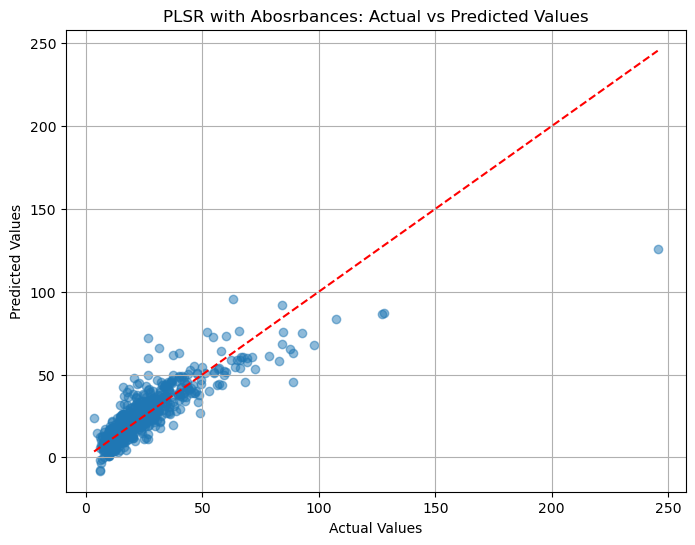

In [76]:
# Plot Spectra
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_absorb[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'Absorbance'],
    title='Comparison of Multiple Soil Spectra'
)

plsr_absorb_components = own_functions.optimize_pls_components(X_train=X_train_absorb, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=False,
                                      plot_results=False
                                      )


plsr_absorb_model = PLSRegression(n_components=plsr_absorb_components["optimal_n"])
plsr_absorb_model.fit(X_train_absorb, y_train)

plsr_absorb_eval = own_functions.evaluate_model(plsr_absorb_model,
                             X_test=X_test_absorb,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with Abosrbances',
                             'figsize': (8, 6)}
                             )

*Please not that in first plot, it is absorbance instead of reflectance.*

## Strategy 2: Testing Different Models

Our next strategy is to test different models. All models will be trained using the absorbance transformed data, as it led to the best performance so far.

We will test the following models:
- **Long Short-Term Memory (LSTM)**
- **PLSR + LSTM**
- **PLSR +  AutoMl (Autogluon)** 

### LSTM

We do a simple split of our calibration (training) data into training and validation using 20 % for validation. We us this validation set to stop training and select the best model (best epoch). The same strategay was applied in all following LSTM applications.

Early stopping triggered at epoch 544
tensor(327.5641)


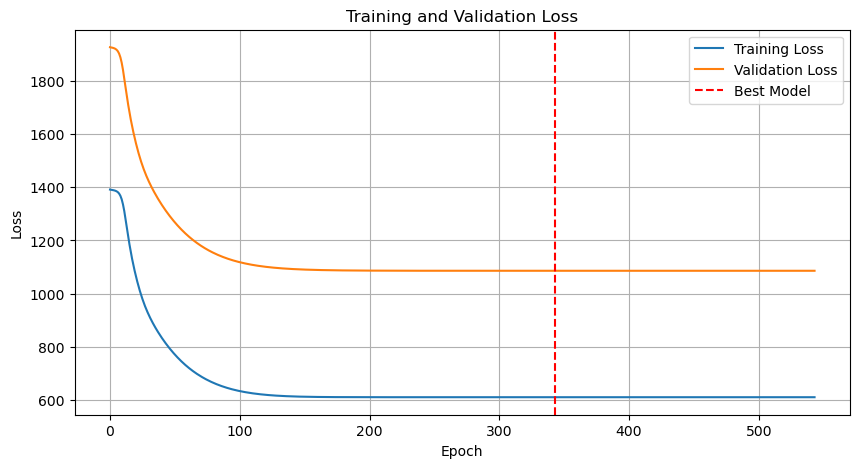

Root Mean Squared Error (RMSE): 18.0987
R²: -0.1172
Bias: 5.8615
RPD: 0.9461


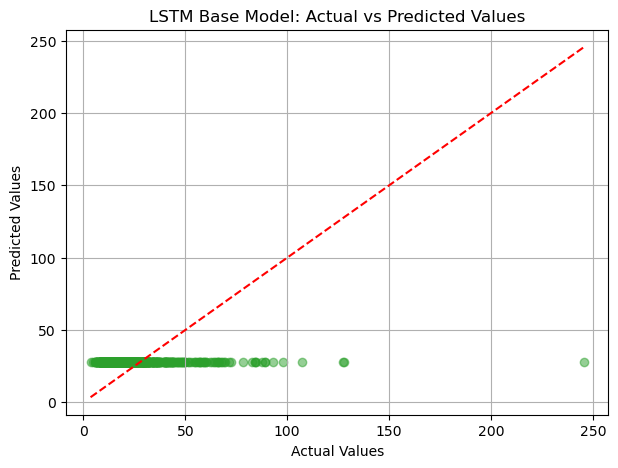

In [81]:
# drop rate 0.2 best
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_absorb, y_train, 
                                                             test_size=0.2, 
                                                             random_state=110)

# Training enhanced LSTM model
LSTM_base_model = own_functions.train_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)



# Evaluate LSTM model
_ = own_functions.evaluate_model(LSTM_base_model, 
                             X_test=X_test_absorb, y_test=y_test, 
                             print_metrics=True, show_plot=True,
                             plot_kwargs={'model_name': 'LSTM Base Model',
                                          'color': "#2ca02c"}
                             )

### LSTM with PLSR components

Next we will use the PLSR model trained on the absorbance transformed data to extract the latent variables and use them as input to the LSTM model. This is done to see if the latent variables extracted by the PLSR model can be used to improve the performance of the LSTM model.

In [79]:
# Fit PLSR on the training data and transform the training set
X_train_pls = plsr_absorb_model.transform(X_train_absorb)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = plsr_absorb_model.transform(X_test_absorb)

# Show number of components
print(f"PLSR components: {plsr_absorb_model.n_components}")
print(f"Shape of transformed training data: {X_train_pls.shape}")

PLSR components: 48
Shape of transformed training data: (1964, 48)


Early stopping triggered at epoch 1929
tensor(42.8820)


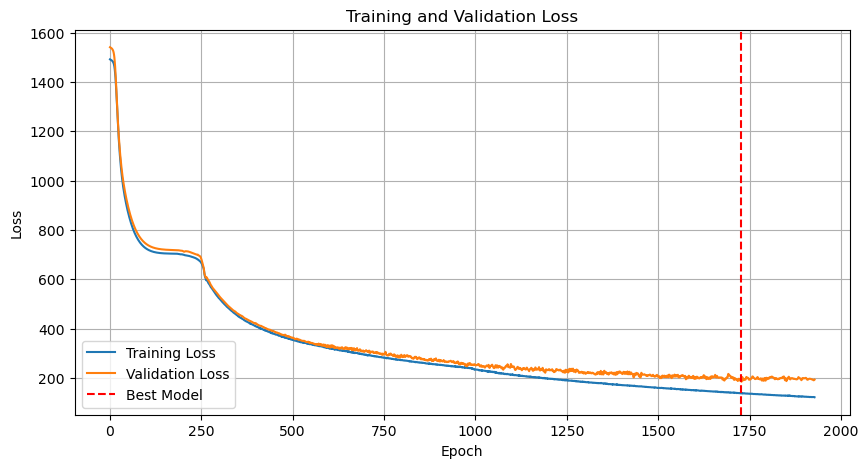

Root Mean Squared Error (RMSE): 6.5484
R²: 0.8537
Bias: -0.7114
RPD: 2.6149


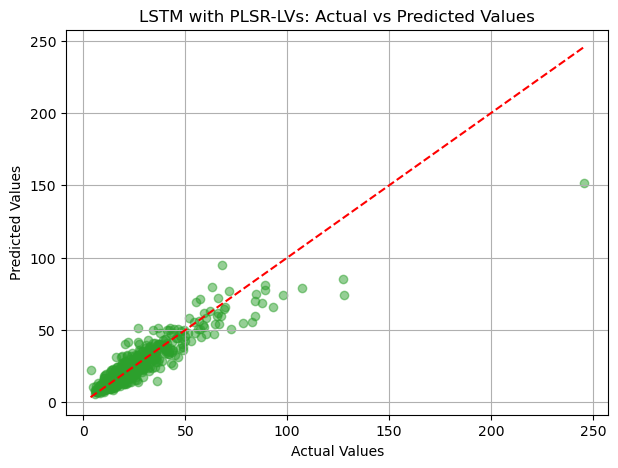

In [80]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_pls, y_train, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_plsr_model= own_functions.train_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_pls,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2,
    show_training=False
)


lstm_plsr_eval = own_functions.evaluate_model(LSTM_plsr_model, 
                             X_test=X_test_pls, y_test=y_test, 
                             print_metrics=True, show_plot=True,
                            plot_kwargs={'model_name': 'LSTM with PLSR-LVs',
                                          'color': "#2ca02c"}
                             )

### Plsr + AutoML

Using the latent variables from the plsr model led to a significant performance increase in the LSTM model. Therefore we will use the latent variables from the PLSR model also to train an AutoML model using Autogluon.
Autogluon is a AutoML library that can be used to train a wide range of models. It will apply 15 different models, including but not limited to:
- Random Forest
- XGBoost
- CatBoost
- K-Nearest Neighbors
- Neural Networks
- Weighted Ensemble
 ***

For autogluon we need to setup our data in dataframes.

In [ ]:
# Convert numpy arrays to DataFrame with wavelength columns
wavelengths = range(500, 2500, 2)  # Your wavelength range
train_df = pd.DataFrame(X_train_pls, columns=range(1, X_train_pls.shape[1] + 1))
test_df = pd.DataFrame(X_test_pls, columns=range(1, X_train_pls.shape[1] + 1))

# Add target variable
train_df['SOC'] = y_train
test_df['SOC'] = y_test

Now we can simply run the TabularPredictor.

In [ ]:
# More advanced configuration with safety measures
auto_predictor = TabularPredictor(
    label='SOC',
    problem_type="regression",
    eval_metric='root_mean_squared_error',
).fit(
    train_df,
    presets='best_quality',
    num_gpus=0,
    num_cpus=1,
    memory_limit='auto',
    auto_stack=False,
    verbosity=0
)

We are provided with a model leaderboard.

In [ ]:
# Get leaderboard
auto_leaderbord = auto_predictor.leaderboard(test_df)

# Show leaderboard
print("\nModel Leaderboard:")
print(auto_leaderbord[1:10,["model", "score_test",
                       "fit_time","pred_time_test"]])

predictor path is c:\Users\luis_\Desktop\Alles\Uni\Leipzig\WS_24_25\spectroscopy\final_project\soc_modelling\AutogluonModels\ag-20250225_124446

Model Leaderboard:
                   model  score_test  score_val              eval_metric  \
0   NeuralNetFastAI_r191   -6.465653  -7.858265  root_mean_squared_error   
1    WeightedEnsemble_L2   -6.565789  -7.667403  root_mean_squared_error   
2          CatBoost_r137   -7.100844 -10.370113  root_mean_squared_error   
3               CatBoost   -7.319287  -9.634744  root_mean_squared_error   
4          CatBoost_r177   -7.464913  -9.398295  root_mean_squared_error   
5        NeuralNetFastAI   -7.833119  -8.503627  root_mean_squared_error   
6           CatBoost_r13   -8.104972  -8.996269  root_mean_squared_error   
7            CatBoost_r9   -8.638408  -9.252907  root_mean_squared_error   
8                XGBoost   -8.678744 -11.231818  root_mean_squared_error   
9            XGBoost_r33   -9.264493 -10.793384  root_mean_squared_error   


We automatically use the best predictor, using the predict function.

Root Mean Squared Error (RMSE): 6.5658
R²: 0.8530
Bias: -0.5860
RPD: 2.6080


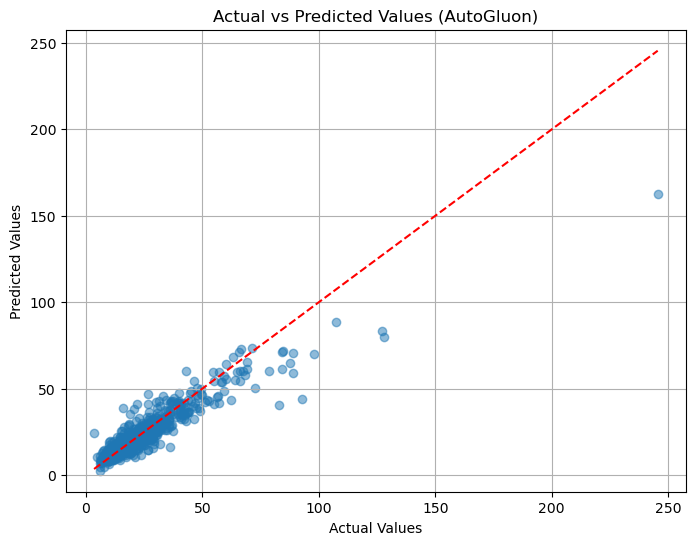

In [ ]:
# Get predictions and evaluate
y_pred_auto = auto_predictor.predict(test_df.drop(columns=['SOC']))

# Evaluate using your existing function
autogluon_eval = own_functions.evaluate_model(
    auto_predictor,
    X_test=test_df.drop(columns=['SOC']), 
    y_test=test_df['SOC'],
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'AutoGluon', 'figsize': (8, 6), 'color': '#d62728'}
)

## Stragtegy 3: Testing auxillary data 

Our 3rd strategy is to test the effect of adding auxiliary data to the model. We will use the best performing model from the previous strategies, the PLSR + LSTM using absorbance transformed data. 

We will use the following auxiliary data:

- **DLR SoilSuite: spectral composite data**
- **ISRIC SoilGrids: soil information**

### DLR SoilSuite Spectral Data

The DLR SoilSuite dataset is a recently released collection of different image data products that provide information about the spectral and statistical properties of European soils and other bare surfaces such as rocks. It utilizes Sentinel-2 data to generate composite images based on observations recorded between January 2018 and December 2022 across Europe.


Properties:

- 20 meter resolution
- 10 Sentinel-2 bands (B02, B03, B04, B05, B06, B07, B08, B08a, B11, B12)
- 5-year composite (2018-2022)
- Continental coverage (Europe)
- Cloud cover filter: excludes scenes with >80% cloud cover
- Sun elevation filter: excludes scenes with <20 degrees elevation

Used variables:
- MREF: Mean reflactances excluding snow and cloud pixels
- SDREF: Standard deviation of reflectances, indicating spectral variability

We also used MREF to calculate a suite of 10 spectral vegetation and soil indices to add to our data:
- **Vegetation Indices**: NDVI, GNDVI, EVI, SAVI, OSAVI
- **Soil Indices**: BI, NDSoI, MBI, NSDS, NSDSI1


*Note: The product also includes bands on bare surface properties, these were not used however as for many points in the LUCAS dataset, no data was available.*

For more Information go to: 
https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S2-soilsuite-europe-2018-2022-P5Y

***

Read data.

In [41]:
dlr_data = gpd.read_parquet("data/auxiliary_data_results_full_updated.parquet")

dlr_data


,y,x,spatial_ref,time,MREF_B02,MREF_B03,MREF_B04,MREF_B05,MREF_B06,MREF_B07,...,SRC-CI95_B07,SRC-CI95_B08,SRC-CI95_B8A,SRC-CI95_B11,SRC-CI95_B12,SFREQ-BSF,point_index,source_lon,source_lat,geometry
0,2548010.0,3902010.0,3035,2018-03-01,567,927,946,1516,2854,3278,...,-10000,-10000,-10000,-10000,-10000,0.000000,3,4.601575,45.908022,POINT (3902010.000 2548010.000)
1,2545990.0,3908010.0,3035,2018-03-01,399,688,706,1206,2248,2535,...,-10000,-10000,-10000,-10000,-10000,0.000000,0,4.680379,45.893933,POINT (3908010.000 2545990.000)
2,2555990.0,3907990.0,3035,2018-03-01,556,936,937,1369,2652,3044,...,-10000,-10000,-10000,-10000,-10000,0.000000,2,4.671533,45.983716,POINT (3907990.000 2555990.000)
3,2537990.0,3899990.0,3035,2018-03-01,232,466,446,934,2171,2600,...,-10000,-10000,-10000,-10000,-10000,0.000000,1,4.584692,45.816720,POINT (3899990.000 2537990.000)
4,2577990.0,3896010.0,3035,2018-03-01,431,766,805,1357,2684,3088,...,-10000,-10000,-10000,-10000,-10000,0.000000,5,4.497083,46.173451,POINT (3896010.000 2577990.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2636010.0,3598010.0,3035,2018-03-01,446,753,731,1300,2789,3257,...,-10000,-10000,-10000,-10000,-10000,0.000000,497,0.575760,46.423743,POINT (3598010.000 2636010.000)
2801,2869990.0,3372010.0,3035,2018-03-01,298,620,463,1110,3074,3760,...,-10000,-10000,-10000,-10000,-10000,0.000000,1671,-2.833854,48.198354,POINT (3372010.000 2869990.000)
2802,2620010.0,3788010.0,3035,2018-03-01,485,803,833,1367,2744,3216,...,67,76,73,82,66,0.036458,2204,3.056281,46.468860,POINT (3788010.000 2620010.000)
2803,2795990.0,3357990.0,3035,2018-03-01,498,752,882,1234,2217,2610,...,193,203,208,240,228,0.166667,2410,-2.852118,47.522143,POINT (3357990.000 2795990.000)


Select the appropriate variables.

In [42]:
dlr_measurements = ["MREF_B02", "MREF_B03", "MREF_B04", "MREF_B05", "MREF_B06", "MREF_B07", "MREF_B08", "MREF_B8A", "MREF_B11", "MREF_B12",  # Mean Reflectance bands
                        "MREF-STD_B02", "MREF-STD_B03", "MREF-STD_B04", "MREF-STD_B05", "MREF-STD_B06", "MREF-STD_B07", "MREF-STD_B08", "MREF-STD_B8A", "MREF-STD_B11", "MREF-STD_B12",  # Standard deviation bands
                        ]

Two of our Lucas samples have incorrect coordinates with both lattitude and longitude beeing 88.88888. These samples had to be excluded. Also we need to find the correct indices to add the auxillary data to the Lucas data. 

In [46]:
# check if any lon is 88.8888 and lat is 88.8888
target_raw[target_raw['GPS_LONG'].isin([88.888888])]

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
513,514,10589,13.0,43.0,44.0,69.9,1,2.4,0.0,55.0,15.3,X,88.888888,88.888888,C10,8,U120,8,mineral,FRANCE
935,936,11065,34.0,50.0,17.0,21.6,7,2.4,30.5,288.6,28.4,X,88.888888,88.888888,B32,8,U111,8,mineral,FRANCE


Get valid indices and select the auxillary data.

In [ ]:
original_ks_indices = ks_indices
original_test_indices = test_indices

# Create a mapping from original indices to rows in the auxiliary data
point_to_row = dict(zip(dlr_data['point_index'], dlr_data.index))

# Filter indices to only include those with data in dlr_data
valid_ks_indices = [idx for idx in original_ks_indices if idx in point_to_row]
valid_test_indices = [idx for idx in original_test_indices if idx in point_to_row]

# Map original indices to row positions in dlr_data
mapped_ks_indices = [point_to_row[idx] for idx in valid_ks_indices]
mapped_test_indices = [point_to_row[idx] for idx in valid_test_indices]

# Now use these mapped indices to select data
dlr_train_ks = dlr_data.iloc[mapped_ks_indices]
dlr_test_ks = dlr_data.iloc[mapped_test_indices]


Original indices: 1964 training, 843 test
Valid indices with aux data: 1962 training, 843 test


Calculate vegetation and soil indices.

In [ ]:
# Calculate indices
indices_train_ks = own_functions.compute_indices(dlr_train_ks)
indices_test_ks = own_functions.compute_indices(dlr_test_ks)

Combine DLR spectral and indeices data.

In [ ]:
# Combine indices with original data
dlr_train_ks = pd.concat([dlr_train_ks[dlr_measurements], indices_train_ks], axis=1)
dlr_test_ks = pd.concat([dlr_test_ks[dlr_measurements], indices_test_ks], axis=1)

# Print shapes
print(f"Original indices: {len(original_ks_indices)} training, {len(original_test_indices)} test")
print(f"Valid indices with aux data: {len(valid_ks_indices)} training, {len(valid_test_indices)} test")

In [ ]:
# Convert to numpy arrays
dlr_train_ks = dlr_train_ks.values
dlr_test_ks = dlr_test_ks.values

# Print number of rows containing NaN values
print(f"NaN values in DLR Train data: {np.isnan(dlr_train_ks).sum()}")

dlr_train_ks = np.nan_to_num(dlr_train_ks, nan=0, posinf=0, neginf=0)
dlr_test_ks = np.nan_to_num(dlr_test_ks, nan=0, posinf=0, neginf=0)

print(f"Auxillary DLR Train data shape: {dlr_train_ks.shape}")
print(f"Auxillary DLR Test data shape: {dlr_test_ks.shape}")

NaN values in DLR Train data: 48
Auxillary DLR Train data shape: (1962, 38)
Auxillary DLR Test data shape: (843, 38)


Select the matching datapoints from the LUCAS-Data. Excluding two samples from the training data with incorrect coordinates.

In [40]:
# Map from original index to position in X_train_absprb
original_to_train_pos = {orig_idx: train_pos for train_pos, orig_idx in enumerate(ks_indices)}

# Find the positions in X_train_absprb that correspond to valid_ks_indices
train_absprb_positions = []
for idx in valid_ks_indices:
    if idx in original_to_train_pos:
        train_absprb_positions.append(original_to_train_pos[idx])

# Now use these positions to select from X_train_absprb
X_train_absprb_dlr = X_train_absorb[train_absprb_positions, :]
y_train_dlr = y_train[train_absprb_positions]

# Do the same for test data
original_to_test_pos = {orig_idx: test_pos for test_pos, orig_idx in enumerate(test_indices)}

test_absprb_positions = []
for idx in valid_test_indices:
    if idx in original_to_test_pos:
        test_absprb_positions.append(original_to_test_pos[idx])

X_test_absprb_dlr = X_test_absorb[test_absprb_positions, :]
y_test_dlr = y_test[test_absprb_positions]

# Print shapes
print(f"Original data shapes: {X_train_absorb.shape}, {X_test_absorb.shape}")
print(f"X_train_absorb_dlr shape: {X_train_absprb_dlr.shape}")
print(f"X_test_absprb_dlr shape: {X_test_absprb_dlr.shape}")
print(f"y_train_dlr shape: {y_train_dlr.shape}")
print(f"y_test_dlr shape: {y_test_dlr.shape}")

NameError: name 'valid_ks_indices' is not defined

In [ ]:
# Add the auxiliary data to the PLSR transformed data
X_train_combined = np.hstack((X_train_absprb_dlr, dlr_train_ks))
X_test_combined = np.hstack((X_test_absprb_dlr, dlr_test_ks))

# Print shapes
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_combined shape: (1962, 1038)
X_test_combined shape: (843, 1038)


Fit PLSR on the combined data.

Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

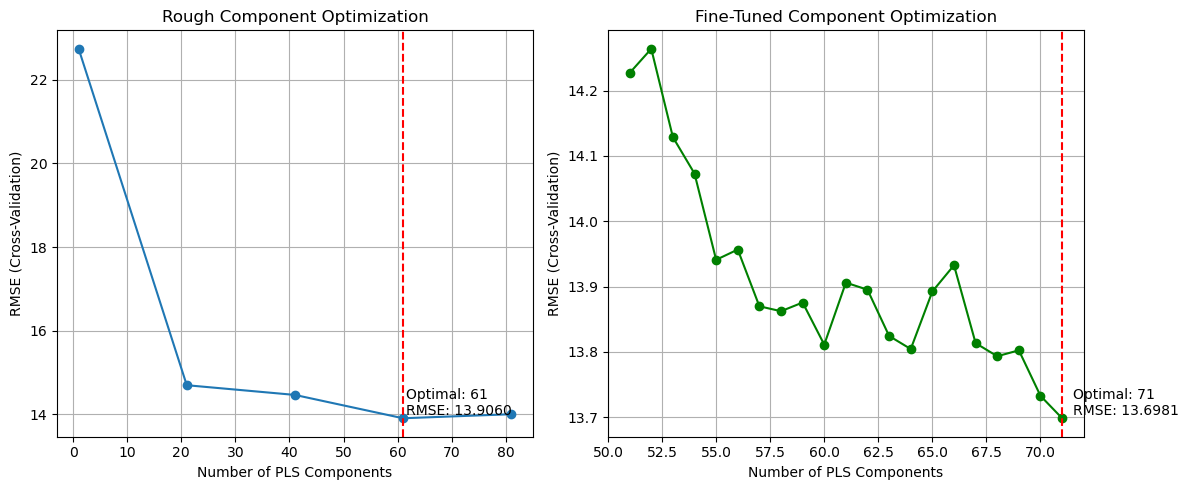

Root Mean Squared Error (RMSE): 8.9545
R²: 0.7265
Bias: 0.2841
RPD: 1.9123


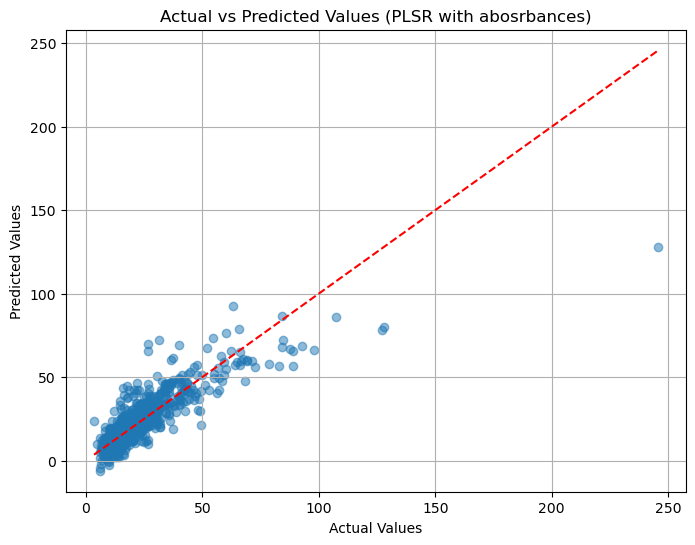

In [ ]:
plsr_dlr_components = own_functions.optimize_pls_components(X_train=X_train_combined, 
                                      y_train=y_train_dlr,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=False,
                                      plot_results=False
                                      )


plsr_absorb_dlr_model = PLSRegression(plsr_dlr_components["optimal_n"])
plsr_absorb_dlr_model.fit(X_train_combined, y_train_dlr)

plsr_absorb_dlr_eval = own_functions.evaluate_model(plsr_absorb_dlr_model,
                             X_test=X_test_combined,
                             y_test=y_test_dlr,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with abosrbances',
                             'figsize': (8, 6), 'color': '#2ca02c'}
                             )

Use Latent Variables from PLSR.

In [ ]:
# transform the data using plsr_absorb_dlr_model
X_train_plsr_absorb_dlr = plsr_absorb_dlr_model.transform(X_train_combined)
X_test_plsr_absorb_dlr = plsr_absorb_dlr_model.transform(X_test_combined)

Fit LSTM on the latent variables of the combined data.

Epoch [10/3000], Train Loss: 1540.5464, Val Loss: 1257.4043
Epoch [20/3000], Train Loss: 1344.9900, Val Loss: 1036.0135
Epoch [30/3000], Train Loss: 1098.5538, Val Loss: 813.5641
Epoch [40/3000], Train Loss: 986.3824, Val Loss: 711.8333
Epoch [50/3000], Train Loss: 917.4670, Val Loss: 647.8571
Epoch [60/3000], Train Loss: 866.9979, Val Loss: 601.1006
Epoch [70/3000], Train Loss: 830.6962, Val Loss: 567.8345
Epoch [80/3000], Train Loss: 805.1898, Val Loss: 544.7816
Epoch [90/3000], Train Loss: 787.6553, Val Loss: 529.2339
Epoch [100/3000], Train Loss: 775.8893, Val Loss: 519.0675
Epoch [110/3000], Train Loss: 768.2424, Val Loss: 512.6531
Epoch [120/3000], Train Loss: 763.3832, Val Loss: 508.7702
Epoch [130/3000], Train Loss: 760.3764, Val Loss: 506.5227
Epoch [140/3000], Train Loss: 758.4575, Val Loss: 505.1368
Epoch [150/3000], Train Loss: 757.2153, Val Loss: 503.8857
Epoch [160/3000], Train Loss: 755.8500, Val Loss: 499.4169
Epoch [170/3000], Train Loss: 753.3842, Val Loss: 498.8031
E

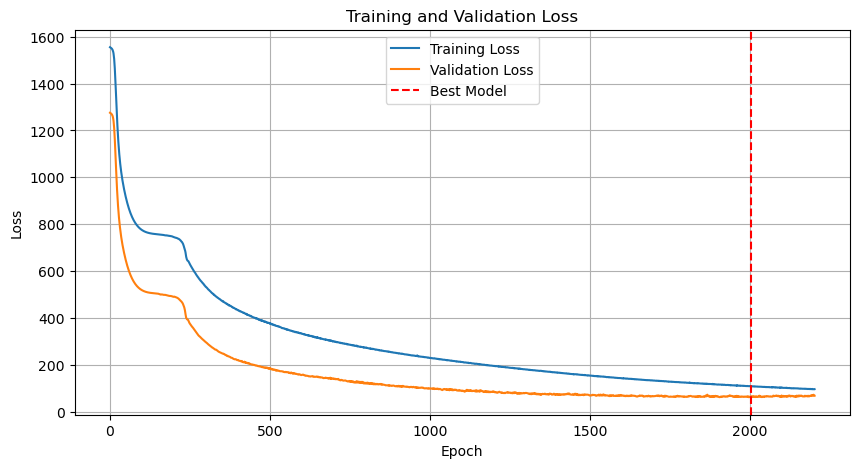

Root Mean Squared Error (RMSE): 6.0841
R²: 0.8738
Bias: -0.3307
RPD: 2.8144


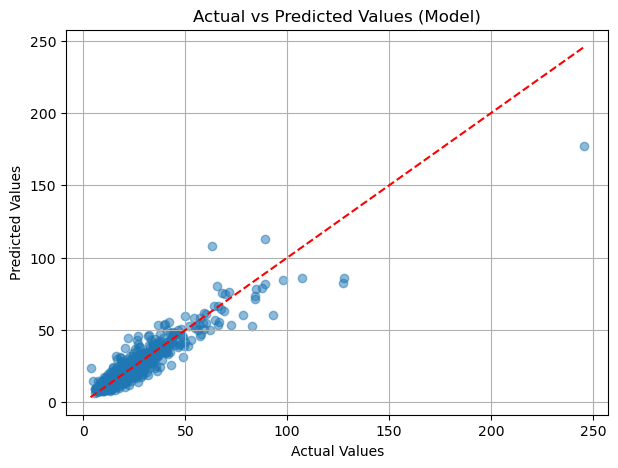

In [ ]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_plsr_absorb_dlr, y_train_dlr, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_plsr_dlr_model= own_functions.train_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_plsr_absorb_dlr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_dlr,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)


lstm_plsr_eval = own_functions.evaluate_model(LSTM_plsr_dlr_model, 
                             X_test=X_test_plsr_absorb_dlr, y_test=y_test_dlr, 
                             print_metrics=True, show_plot=True)

### ISRIC SoilGrids Data

The ISRIC SoilGrids dataset is a comprehensive global soil information system that uses machine learning to map the spatial distribution of soil properties worldwide. It's developed and maintained by ISRIC - World Soil Information.

Properties:

- 250 meter resolution global coverage
- Based on over 230,000 soil profile observations from the WoSIS database


**Modeling Data Sources:**
SoilGrids models are trained using two primary types of data:
1. **Soil profile observations** from the World Soil Information Service (WoSIS) database, containing over 230,000 profiles collected by various national and international soil survey programs worldwide
2. **Environmental covariates** selected from more than 400 layers including:
   - Climate data (temperature, precipitation, seasonality)
   - Remote sensing products (MODIS, Landsat)
   - Terrain attributes (elevation, slope, aspect)
   - Land cover information
   - Lithology and parent material data
   - Vegetation indices and biomass estimates

These data sources are combined using machine learning techniques to predict soil properties globally with quantified uncertainty.

For our study, we used the following soil properties from SoilGrids:
- **Bulk density** (bdod): at 0-5cm, 5-15cm, and 15-30cm depths
- **Clay content** (clay): percentage of clay particles at 0-5cm, 5-15cm, and 15-30cm depths
- **pH in water** (phh2o): soil pH at 0-5cm, 5-15cm, and 15-30cm depths
- **Sand content** (sand): percentage of sand particles at 0-5cm, 5-15cm, and 15-30cm depths
- **Silt content** (silt): percentage of silt particles at 0-5cm, 5-15cm, and 15-30cm depths

These soil physical and chemical properties provide valuable information about soil texture, structure, and composition, which are known to be correlated with soil organic carbon content. By including these properties as auxiliary data, we aim to enhance our predictive models.

Importantly, we deliberately excluded organic carbon-related variables from SoilGrids to avoid circular dependencies in our modeling, as soil organic carbon (SOC) is our target variable.

For more information, visit: https://www.isric.org/explore/soilgrids

Or the Paper: https://soil.copernicus.org/articles/7/217/2021/
***

Load data.

In [ ]:
# read pd from csv
isric_data = pd.read_csv('data/soilgrids_parallel.csv')
isric_data.head()

,point_index,lon,lat,bdod_0_to_5cm_mean,bdod_5_to_15cm_mean,bdod_15_to_30cm_mean,clay_0_to_5cm_mean,clay_5_to_15cm_mean,clay_15_to_30cm_mean,phh2o_0_to_5cm_mean,...,sand_0_to_5cm_mean,sand_5_to_15cm_mean,sand_15_to_30cm_mean,silt_0_to_5cm_mean,silt_5_to_15cm_mean,silt_15_to_30cm_mean,soc_0_to_5cm_mean,soc_5_to_15cm_mean,soc_15_to_30cm_mean,error
0,1,4.584692,45.816720,125.0,134.0,141.0,250.0,270.0,302.0,58.0,...,375.0,366.0,366.0,375.0,364.0,332.0,489.0,249.0,246.0,NaN
1,0,4.680379,45.893933,128.0,138.0,141.0,303.0,319.0,338.0,62.0,...,263.0,243.0,275.0,434.0,438.0,387.0,467.0,254.0,182.0,NaN
2,3,4.601575,45.908022,133.0,140.0,144.0,247.0,268.0,288.0,60.0,...,334.0,320.0,329.0,418.0,412.0,383.0,401.0,289.0,153.0,NaN
3,2,4.671533,45.983716,129.0,139.0,143.0,249.0,254.0,300.0,63.0,...,305.0,295.0,313.0,446.0,451.0,387.0,422.0,271.0,154.0,NaN
4,6,4.439863,46.224665,102.0,116.0,121.0,188.0,172.0,205.0,52.0,...,505.0,514.0,494.0,306.0,314.0,301.0,786.0,620.0,239.0,NaN


Select variables.

In [ ]:
isric_measurements = ["bdod_0_to_5cm_mean", "bdod_5_to_15cm_mean", "bdod_15_to_30cm_mean", 
                      "clay_0_to_5cm_mean", "clay_5_to_15cm_mean", "clay_15_to_30cm_mean", 
                      "phh2o_0_to_5cm_mean", "phh2o_5_to_15cm_mean", "phh2o_15_to_30cm_mean",
                      "sand_0_to_5cm_mean", "sand_5_to_15cm_mean", "sand_15_to_30cm_mean",
                      "silt_0_to_5cm_mean", "silt_5_to_15cm_mean", "silt_15_to_30cm_mean"]

The rest of thie code for the approach is the same as for the DLR-Data:

In [ ]:
# Create a mapping from original indices to rows in the isriciliary data
point_to_row = dict(zip(isric_data['point_index'], isric_data.index))

# Filter indices to only include those with data in isric_data
valid_ks_indices = [idx for idx in original_ks_indices if idx in point_to_row]
valid_test_indices = [idx for idx in original_ks_indices if idx in point_to_row]

# Map original indices to row positions in isric_data
mapped_ks_indices = [point_to_row[idx] for idx in valid_ks_indices]
mapped_test_indices = [point_to_row[idx] for idx in valid_test_indices]

# Now use these mapped indices to select data
isric_train_ks = isric_data.iloc[mapped_ks_indices]
isric_test_ks = isric_data.iloc[mapped_test_indices]

# Print shapes
print(f"Original indices: {len(ks_indices)} training, {len(test_indices)} test")
print(f"Valid indices with isric data: {len(valid_ks_indices)} training, {len(valid_test_indices)} test")

# select only relevant columns
isric_train_ks = isric_train_ks[isric_measurements].values
isric_test_ks = isric_test_ks[isric_measurements].values

isric_train_ks = np.nan_to_num(isric_train_ks, nan=0, posinf=0, neginf=0)
isric_test_ks = np.nan_to_num(isric_test_ks, nan=0, posinf=0, neginf=0)

print(f"Auxillary isric Train data shape: {isric_train_ks.shape}")
print(f"Auxillary isric Test data shape: {isric_test_ks.shape}")

Original indices: 1964 training, 843 test
Valid indices with isric data: 1964 training, 843 test
Auxillary isric Train data shape: (1964, 15)
Auxillary isric Test data shape: (843, 15)


In [ ]:
original_train_indices = ks_indices  # These are the indices used to create X_train_pls

# Map from original index to position in X_train_pls
original_to_train_pos = {orig_idx: train_pos for train_pos, orig_idx in enumerate(original_train_indices)}

# Find the positions in X_train_pls that correspond to valid_ks_indices
train_pls_positions = []
for idx in valid_ks_indices:
    if idx in original_to_train_pos:
        train_pls_positions.append(original_to_train_pos[idx])

# Now use these positions to select from X_train_pls
X_train_pls_isric = X_train_absorb[train_pls_positions, :]
y_train_isric = y_train[train_pls_positions]

# Do the same for test data
original_test_indices = test_indices  # These are the indices used to create X_test_pls
original_to_test_pos = {orig_idx: test_pos for test_pos, orig_idx in enumerate(original_test_indices)}

test_pls_positions = []
for idx in valid_test_indices:
    if idx in original_to_test_pos:
        test_pls_positions.append(original_to_test_pos[idx])

X_test_pls_isric = X_test_absorb[test_pls_positions, :]
y_test_isric = y_test[test_pls_positions]

# Print shapes
print(f"X_train_pls_isric shape: {X_train_pls_isric.shape}")
print(f"X_test_pls_isric shape: {X_test_pls_isric.shape}")
print(f"y_train_isric shape: {y_train_isric.shape}")
print(f"y_test_isric shape: {y_test_isric.shape}")

# Add the isriciliary data to the PLSR transformed data
X_train_combined = np.hstack((X_train_pls_isric, isric_train_ks))
X_test_combined = np.hstack((X_test_pls_isric, isric_test_ks))

# standardize the data
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# Print shapes
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_pls_isric shape: (1964, 1000)
X_test_pls_isric shape: (843, 1000)
y_train_isric shape: (1964,)
y_test_isric shape: (843,)
X_train_combined shape: (1964, 1015)
X_test_combined shape: (843, 1015)


Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

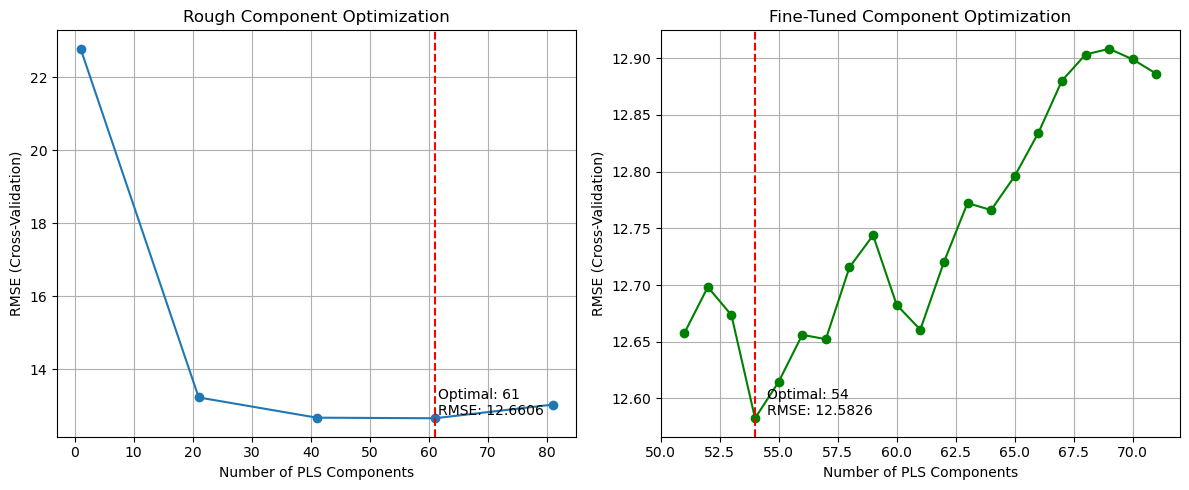

Root Mean Squared Error (RMSE): 8.7390
R²: 0.7395
Bias: 0.7804
RPD: 1.9594


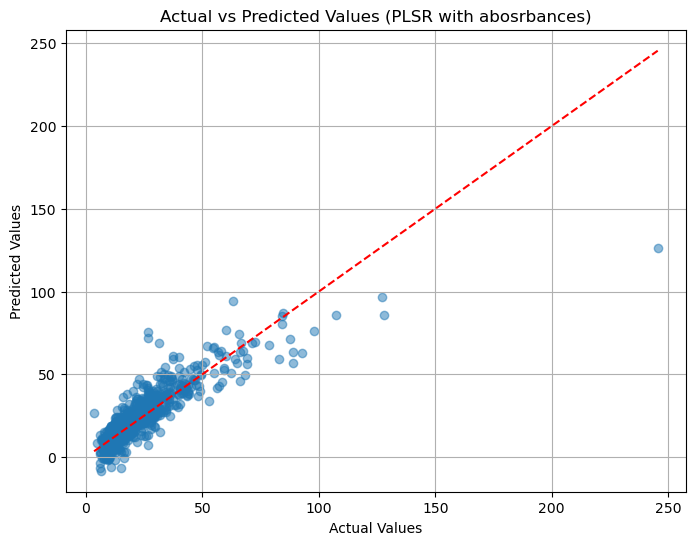

In [ ]:
plsr_isric_components = own_functions.optimize_pls_components(X_train=X_train_combined, 
                                      y_train=y_train_isric,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )


plsr_absorb_aux_model = PLSRegression(n_components=plsr_isric_components["optimal_n"])
plsr_absorb_aux_model.fit(X_train_combined, y_train_isric)

plsr_absorb_aux_eval = own_functions.evaluate_model(plsr_absorb_aux_model,
                             X_test=X_test_combined,
                             y_test=y_test_isric,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with abosrbances',
                             'figsize': (8, 6)}
                             )

In [ ]:
X_train_comb_plsr = plsr_absorb_aux_model.transform(X_train_combined)
X_test_comb_plsr = plsr_absorb_aux_model.transform(X_test_combined)

In [ ]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_comb_plsr, y_train_isric, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_aux_model= own_functions.train_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_comb_plsr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_isric,
    hidden_size=256,
    num_layers=5,
    num_epochs=4000,
    learning_rate=0.001,
    patience=300,  # Early stopping patience
    dropout=0.2
)


lstm_eval = own_functions.evaluate_model(LSTM_aux_model, 
                             X_test=X_test_comb_plsr, y_test=y_test_isric, 
                             print_metrics=True, show_plot=True)

Epoch [10/4000], Train Loss: 1475.2972, Val Loss: 1519.5110
Epoch [20/4000], Train Loss: 1280.4115, Val Loss: 1283.1000
Epoch [30/4000], Train Loss: 1040.9993, Val Loss: 1062.2501
Epoch [40/4000], Train Loss: 929.5973, Val Loss: 954.4364
Epoch [50/4000], Train Loss: 861.1890, Val Loss: 885.2343
Epoch [60/4000], Train Loss: 811.6935, Val Loss: 834.5779
Epoch [70/4000], Train Loss: 775.9415, Val Loss: 797.5146
Epoch [80/4000], Train Loss: 750.5928, Val Loss: 770.7653
Epoch [90/4000], Train Loss: 732.1863, Val Loss: 751.7930
Epoch [100/4000], Train Loss: 718.9263, Val Loss: 738.2095
Epoch [110/4000], Train Loss: 709.2322, Val Loss: 727.8226
Epoch [120/4000], Train Loss: 702.1847, Val Loss: 720.2368
Epoch [130/4000], Train Loss: 696.5098, Val Loss: 714.1851
Epoch [140/4000], Train Loss: 691.6286, Val Loss: 708.9233
Epoch [150/4000], Train Loss: 686.7952, Val Loss: 703.0333
Epoch [160/4000], Train Loss: 676.5783, Val Loss: 696.5714
Epoch [170/4000], Train Loss: 660.6702, Val Loss: 671.7918


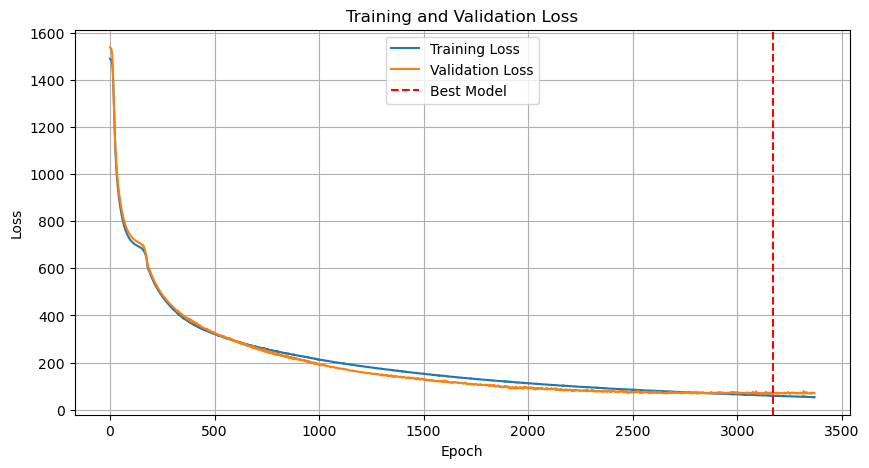

Root Mean Squared Error (RMSE): 5.7093
R²: 0.8888
Bias: -0.2987
RPD: 2.9992


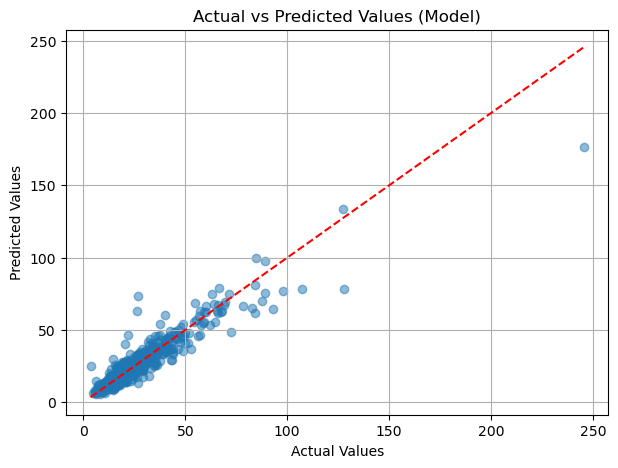

In [ ]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_comb_plsr, y_train_isric, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_aux_model= own_functions.train_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_comb_plsr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_isric,
    hidden_size=256,
    num_layers=5,
    num_epochs=4000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)


lstm_eval = own_functions.evaluate_model(LSTM_aux_model, 
                             X_test=X_test_comb_plsr, y_test=y_test_isric, 
                             print_metrics=True, show_plot=True)

## 3. **Overview for Model Improvement Strategies** (5 P per strategy)

### Model Improvement Strategies

To enhance the baseline model, we have implemented three distinct strategies  and evaluated using the same independent test set for validation. 

#### Strategy 1: Varying Preprocessing Techniques

1. **Savitzky-Golay Filter:**
   - **Process:** Applied the  Savitzky-Golay filter to both calibration and test data to smooth the spectral data.
   - **Metrics:**
     - RMSE: 10.1694
     - R²: 0.6473
     - Bias: -0.1207
     - RPD: 1.6838

2. **Standard Normal Variate (SNV):**
   - **Process:** Applied SNV to normalize spectral data, reducing variability due to differences in illumination.
   - **Metrics:**
     - RMSE: 10.1517
     - R²: 0.6485
     - Bias: 0.3009
     - RPD: 1.6867

3. **Absorbance Transformation:**
   - **Process:** Converted reflectance data to absorbance to enhance spectral features.
   - **Metrics:**
     - RMSE: 8.6069
     - R²: 0.7474
     - Bias: 0.1506
     - RPD: 1.9895

**Overview:** Preprocessing techniques such as the Savitzky-Golay filter, SNV, and absorbance transformation were applied to improve model performance. The Savitzky-Golay Filter, as well as the SNV-Transfomration did not lead to an improvement of the results. Transforming reflactance to pseudo-absorbance however, led to a strong increase in performance compard to the baseline model, from an RPD of 1.703 to 1.989. So, in further stragies we have used absorbances as independened variables.

#### Strategy 2: Testing Different Models

1. **PyTorch LSTM:**
   - **Process:** Implemented an LSTM model using PyTorch to capture temporal dependencies in spectral data. The LSTM model was designed to leverage the sequential nature of spectral measurements to improve predictive accuracy.
   - **Metrics:**
     - **RMSE:** 18.0296
     - **R²:** -0.1087
     - **Bias:** 5.6444
     - **RPD:** 0.9497

2. **LSTM with PLSR Components:**
   - **Process:** Combined PLSR with LSTM to leverage both dimensionality reduction and temporal modeling. Here, we used the optimal number of components obtained from PLSR, transformed the data, and applied LSTM on the transformed latent variables. This approach aimed to benefit from the strengths of both PLSR and LSTM.
   - **Metrics:**
     - **RMSE:** 6.2590
     - **R²:** 0.8664
     - **Bias:** -0.4263
     - **RPD:** 2.7358

3. **PLSR + AutoML (AutoGluon):**
   - **Process:** Utilized AutoGluon, an automated machine learning library, to optimize model selection and hyperparameters. AutoGluon selected NeuralNetFastAI_r191 as the top model on the leaderboard. We applied PLSR in combination with NeuralNetFastAI_r191 to enhance predictive performance.
   - **Reference:** [AutoGluon Documentation](https://auto.gluon.ai/stable/index.html)
   - **Metrics:**
     - **RMSE:** 6.5658
     - **R²:** 0.8530
     - **Bias:** -0.5860
     - **RPD:** 2.6080

**Overview:** Different modeling approaches, including LSTM and AutoML, were tested to improve predictive performance. While the direct application of LSTM did not yield satisfactory results so we tried to  combine PLSR with LSTM in 2nd part of stragety 2 which yieded good result and using AutoML has given satisfactory results with three lines of code.



#### Strategy 3: Incorporating Auxiliary Data

1. **DLR Auxiliary Data:**
   - **Source:** The auxiliary data was sourced from the German Aerospace Center (DLR), specifically from their [soil suite collection for Europe spanning 2018 to 2022](https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S2-soilsuite-europe-2018-2022-P5Y).
   - **Data Description:** This dataset includes various soil properties and spectral measurements, providing a comprehensive view of soil characteristics across Europe.
   - **Integration:** The DLR data was integrated with the existing spectral data to enhance the model by providing additional features that capture soil variability and properties.
   - **Metrics:**
     - **RMSE:** 6.0841
     - **R²:** 0.8738
     - **Bias:** -0.3307
     - **RPD:** 2.8144

2. **ISRIC Soil Data:**
   - **Source:** The ISRIC (International Soil Reference and Information Centre) soil data was obtained from [SoilGrids](https://www.isric.org/explore/soilgrids), a global soil information system.
   - **Data Description:** This dataset includes detailed soil properties such as bulk density, clay content, pH, sand, and silt content at various soil depths. Care was taken not to include the parameter , which would be close to SOC.
   - **Integration:** The ISRIC data was merged with the spectral data to provide a richer set of features, allowing the model to better understand and predict soil organic carbon (SOC) based on both spectral and soil property information.
   - **Metrics:**
     - **RMSE:** 5.7093
     - **R²:** 0.8888
     - **Bias:** -0.2987
     - **RPD:** 2.9992

**Overview:** Incorporating auxiliary data from DLR and ISRIC  improved model performance by providing additional context and features for more accurate predictions. These datasets stragegy worked relatively better, as it include more information




### Consolidated Evaluation Metrics

| Strategy                      | RMSE    | R²      | Bias     | RPD     |
|-------------------------------|---------|---------|----------|---------|
| **Baseline Model**           | 10.0547 | 0.6552  | -0.1772  | 1.7030  |
| **Savitzky-Golay Filter**    | 10.1694 | 0.6473  | **-0.1207**  | 1.6838  |
| **Standard Normal Variate**  | 10.1517 | 0.6485  | 0.3009   | 1.6867  |
| **Absorbance Transformation**| 8.6069  | 0.7474  | 0.1506   | 1.9895  |
| **PyTorch LSTM**             | 18.0296 | -0.1087 | 5.6444   | 0.9497  |
| **LSTM with PLSR**          | 6.2590  | ***0.8664***  | -0.4263  | ***2.7358***  |
| **PLSR + AutoML**            | 6.5658  | 0.8530  | -0.5860  | 2.6080  |
| **DLR Auxiliary Data**       | 6.0841  | 0.8738  | -0.3307  | 2.8144  |
| **ISRIC Soil Data**          | **5.7093**  | **0.8888**  | -0.2987  | **2.9992**  |

**Conclusion:** As explained before , Incorporating auxilary data **ISRIC Soil Data** worked best compared to all strageties , and if we dont consider , inclusion of new data , then  **LSTM with PLSR**   worked relatively better.


# Discussion of Results (5 P):
- Briefly discuss your results and interpret them based on the validation metrics for the
test set. 
- Compare your findings with those of published studies in a similar context.
- Evaluate whether soil VNIR reflectance spectroscopy could serve as a complementary
approach for large-scale soil organic carbon assessment in Earth (system) science.

**Additional Information:**

The length of the discussion section really depends on your results, but as a general guideline, I would expect it to be around one page.

- **Focus on**: 
  - directly comparing your different modeling approaches 
  - interpreting which performed best based on the validation metrics
- If the results are not as good as expected:
  - consider discussing possible reasons and suggesting ways to improve them 
  - (you might find 1-2 examples from the literature helpful here).

- Additionally, you could compare your findings with similar studies that have attempted to model SOC (or related properties) at national or continental scales using spectroscopy—ideally referencing 2-3 relevant publications.

- Finally, reflect on whether and how soil VNIR spectroscopy could contribute to large-scale soil information systems. 
  - This is a more theoretical aspect, and you are free in how you approach this point. 
  - Important aspects to consider might include:
    - a) Model accuracy (What would be considered a good accuracy in this context?)
    - b) Data harmonization (Challenges when combining datasets from different providers)
    - c) Practical usability (Would end users require programming skills, etc.?)

A recent publication that could provide a useful overview is:
Peng et al. (2025): Spectroscopic solutions for generating new global soil information
(Link: https://www.sciencedirect.com/science/article/pii/S2666675825000426)"

### 4.Discussion of Results

#### Overview of Modeling Approaches

In this study, various modeling approaches were explored to predict soil organic carbon (SOC) using soil VNIR reflectance spectroscopy. The strategies included traditional machine learning techniques such as Partial Least Squares Regression (PLSR), as well as advanced deep learning models like  Long Short-Term Memory networks (LSTM). Each approach was evaluated based on validation metrics such as RMSE, R², bias, and RPD.

#### Performance Comparison

- **PLSR:** The baseline PLSR model demonstrated moderate performance with an RMSE of 10.0547 and an R² of 0.6552. This model served as a benchmark for evaluating the effectiveness of more complex models.

- **Deep Learning Models:**
  - **LSTM:** The standalone LSTM model did not perform well, with an RMSE of 18.0296 and a negative R² value, indicating poor predictive accuracy.
  - **LSTM with PLSR Components:** Combining LSTM with PLSR significantly improved performance, achieving an RMSE of 6.2590 and an R² of 0.8664. This approach leveraged the strengths of both dimensionality reduction and temporal modeling.
  - **PLSR + AutoML (AutoGluon):** Utilizing AutoGluon for automated machine learning further enhanced predictive accuracy, with an RMSE of 6.5658 and an R² of 0.8530.

- **Auxiliary Data Integration:**
  - **DLR Auxiliary Data:** Incorporating DLR auxiliary data improved model performance, resulting in an RMSE of 6.0841 and an R² of 0.8738.
  - **ISRIC Soil Data:** The integration of ISRIC soil data yielded the best results, with an RMSE of 5.7093 and an R² of 0.8888.

#### Comparison with Published Studies

The following table compares the performance metrics of different models from this study with those reported in similar published studies:

| Study/Model                      | RMSE    | R²      | Bias     | RPD     | Reference                                                                 |
|----------------------------------|---------|---------|----------|---------|---------------------------------------------------------------------------|
| **Baseline PLSR**                | 10.0547 | 0.6552  | -0.1772  | 1.7030  | This Study                                                               |
| **LSTM**                         | 18.0296 | -0.1087 | 5.6444   | 0.9497  | This Study                                                               |
| **LSTM with PLSR**              | 6.2590  | 0.8664  | -0.4263  | 2.7358  | This Study                                                               |
| **PLSR + AutoML**                | 6.5658  | 0.8530  | -0.5860  | 2.6080  | This Study                                                               |
| **DLR Auxiliary Data**           | 6.0841  | 0.8738  | -0.3307  | 2.8144  | This Study                                                               |
| **ISRIC Soil Data**              | 5.7093  | 0.8888  | -0.2987  | 2.9992  | This Study                                                               |
| **AutoEncoders (2021)**          | 10.40   | 0.87    | -        | -       | [AutoEncoders Paper](https://doi.org/10.1016/j.geoderma.2021.114967)     |
| **CNN with SG and SNV (2024)**   | 8.48    | 0.81    | -        | -       | [CNN with SG and SNV Paper](https://doi.org/10.1016/j.geoderma.2024.116903) |
| **N-MBL (2024)**                 | 6.21    | 0.70    | -        | 2.12    | [N-MBL Paper](https://doi.org/10.1016/j.ecoinf.2024.102615)             |
| **SAE-1DCNN (2024)**             | 3.935%  | 0.784   | -        | 3.914   | [SAE-1DCNN Paper](https://doi.org/10.1016/j.scitotenv.2024.160783)      |
| **HKF-GPR (2024)**               | 5.29    | 0.7671  | -        | 2.5789  | [HKF-GPR Paper](https://doi.org/10.1016/j.catena.2024.106903)           |
| **LSTM-CNN (2024)**              | 1.66    | 0.96    | -        | -       | [LSTM-CNN Paper](https://doi.org/10.3390/s21124127)                     |

#### Reflection on Soil VNIR Spectroscopy

Soil VNIR reflectance spectroscopy shows promise as a complementary approach for large-scale SOC assessment. Key considerations include:

- **Model Accuracy:** Achieving high accuracy is crucial for reliable SOC predictions. Our best model, which integrated ISRIC soil data, demonstrated strong performance with an R² of 0.8888, indicating its potential for practical applications.

- **Data Harmonization:** Combining datasets from different providers poses challenges due to variations in data quality and format. Standardizing preprocessing techniques, such as Savitzky-Golay smoothing and SNV transformation, can help mitigate these issues.

- **Practical Usability:** While advanced models like LSTM and CNN offer superior performance, they require significant computational resources and expertise. Simplifying these models or providing user-friendly interfaces could enhance their accessibility for end users.

In conclusion, soil VNIR spectroscopy, combined with advanced modeling techniques and auxiliary data integration, holds significant potential for improving large-scale soil information systems. Future work should focus on refining these models and addressing data harmonization challenges to enhance their practical usability.
